# Project Work - Deep Learning in Vision - Daniel Barco

## 2. Approach : Training the model end to end with a frozen convolutional base

We use VGG16, ResNet152 and Xception. 


In [0]:
# General imports
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf

# Shortcuts to keras if (however from tensorflow)
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard 

# Shortcut for displaying images
def plot_img(img):
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.show()
    
# The target image size can be fixed here (quadratic)
# The ImageDataGenerator() automatically scales the images accordingly (aspect ratio is changed)
image_size = 150

In [0]:
  from google.colab import drive

  drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
%cd '/content/gdrive/My Drive/IDS_DLB_Deep_Learning_Bootcamp/data2'

/content/gdrive/My Drive/IDS_DLB_Deep_Learning_Bootcamp/data2


In [0]:
!ls

bottleneck_features_train.npy
bottleneck_features_train_ResNet152V2.npy
bottleneck_features_train_Xception.npy
bottleneck_features_validation.npy
bottleneck_features_validation_ResNet152V2.npy
bottleneck_features_validation_Xception.npy
checkpoint
model_transfer_learning_without_dataaugmentation.data-00000-of-00002
model_transfer_learning_without_dataaugmentation.data-00001-of-00002
model_transfer_learning_without_dataaugmentation.index
model_transfer_resnet152_v2.data-00000-of-00002
model_transfer_resnet152_v2.data-00001-of-00002
model_transfer_resnet152_v2.index
model_transfer_vgg16.data-00000-of-00002
model_transfer_vgg16.data-00001-of-00002
model_transfer_vgg16.index
model_transfer_Xception_batch-100.data-00000-of-00002
model_transfer_Xception_batch-100.data-00001-of-00002
model_transfer_Xception_batch-100.index
model_transfer_Xception.data-00000-of-00002
model_transfer_Xception.data-00001-of-00002
model_transfer_Xception.index
ResNet152V2_fined_tuned_100epochs2.h5
ResNet152V2_fine

### VGG16

In [0]:
vgg16 = applications.VGG16(include_top=False, weights='imagenet',
                           input_shape=(image_size,image_size,3))


In [0]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import applications

vgg16 = applications.VGG16(include_top=False, weights='imagenet',
                           input_shape=(image_size,image_size,3))

model_freeze_conv = models.Sequential()
model_freeze_conv.add(vgg16)
model_freeze_conv.add(layers.Flatten())
model_freeze_conv.add(layers.Dense(256, activation = 'relu'))
model_freeze_conv.add(layers.Dense(2, activation = 'softmax'))

This is what the model looks like now:

In [0]:
model_freeze_conv.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 514       
Total params: 16,812,610
Trainable params: 16,812,610
Non-trainable params: 0
_________________________________________________________________


As you can see, the convolutional base of VGG16 has 14'714'688 parameters, which is very large. The classifier we are adding on top has 
2 million parameters.

Before we compile a layer and train the model, it is very important to __freeze__  the convolutional base. _Freezing_ a layer or a set of layers means preventing their weights from being updated during training. If you don't do this, then the representations that were previously learned by the convolutional base will be modified during training. Because the `Dense` layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, you freeze  a network by setting its `trainable` attribute to `False`: 

In [0]:
print('This is the number of trainable weights'
     'before freezing the conv base:', len(model_freeze_conv.trainable_weights))

vgg16.trainable = False

print('This is the number of trainable weights'
     'after freezing the conv base:', len(model_freeze_conv.trainable_weights))


This is the number of trainable weightsbefore freezing the conv base: 30
This is the number of trainable weightsafter freezing the conv base: 4


With this setup, only the weights from the two `Dense` layers that we added will be trained. That's a total of four weight tensors: two per layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. If we ever modify weight trainability after compilation, we should then recompile the model, or these changes will be ignored.

Now, we can start training our model, with the same data-augmentation configuration that we used in the previous example.

In [0]:
image_size = 150
batch_size = 64
num_train_images = 2900
num_valid_images = 980
num_classes = 2

class_names = ["dog", "cat"]


# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'training_data',
        target_size=(image_size, image_size),
        classes=class_names,
        batch_size=batch_size)

validation_generator = validation_datagen.flow_from_directory(
        'validation_data',
        target_size=(image_size, image_size),
        classes=class_names,
        batch_size=batch_size)

model_freeze_conv.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_freeze_conv.summary()

Found 2907 images belonging to 2 classes.
Found 985 images belonging to 2 classes.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 514       
Total params: 16,812,610
Trainable params: 2,097,922
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
name = 'vgg16'

tensorboard_2 = TensorBoard(
        log_dir='.\\tensorboard\\' + name + '\\', 
        write_graph=True,
        histogram_freq=0)

In [0]:
epochs = 20

history=model_freeze_conv.fit_generator(
        train_generator,
        steps_per_epoch=num_train_images // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=num_valid_images // batch_size, 
        callbacks=[tensorboard_2])

model_freeze_conv.save_weights('model_transfer_vgg16')

Epoch 1/20
45/45 [==============================] - 22s 489ms/step - loss: 0.8623 - acc: 0.7112 - val_loss: 0.3017 - val_acc: 0.8687
Epoch 2/20
45/45 [==============================] - 21s 460ms/step - loss: 0.3144 - acc: 0.8748 - val_loss: 0.2520 - val_acc: 0.8948
Epoch 3/20
45/45 [==============================] - 20s 442ms/step - loss: 0.2597 - acc: 0.8938 - val_loss: 0.2339 - val_acc: 0.8979
Epoch 4/20
45/45 [==============================] - 20s 439ms/step - loss: 0.2269 - acc: 0.9061 - val_loss: 0.2352 - val_acc: 0.8979
Epoch 5/20
45/45 [==============================] - 19s 425ms/step - loss: 0.2343 - acc: 0.9008 - val_loss: 0.2242 - val_acc: 0.8958
Epoch 6/20
45/45 [==============================] - 19s 433ms/step - loss: 0.1926 - acc: 0.9226 - val_loss: 0.2188 - val_acc: 0.9104
Epoch 7/20
45/45 [==============================] - 20s 443ms/step - loss: 0.1845 - acc: 0.9271 - val_loss: 0.2440 - val_acc: 0.8917
Epoch 8/20
45/45 [==============================] - 19s 433ms/step - 

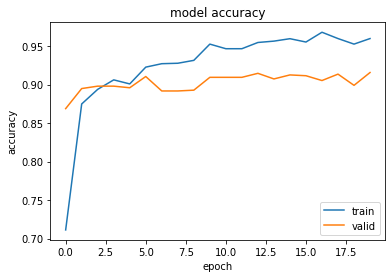

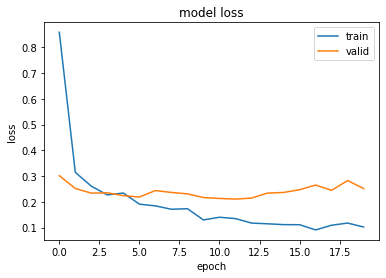

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [0]:
validation_generator_no_shuffle = validation_datagen.flow_from_directory(
        'validation_data',
        target_size=(image_size, image_size),
        batch_size=num_valid_images,
        classes=class_names,
        shuffle=False)


prediction = model_freeze_conv.predict_generator(validation_generator_no_shuffle,1)

Found 985 images belonging to 2 classes.


In [0]:
Y_valid = np.zeros((num_valid_images,1),dtype=int)

step = num_valid_images // num_classes
for ind in range(num_classes):
    Y_valid[ind*step:(ind+1)*step] = ind
    
confmat = confusion_matrix(Y_valid,np.argmax(prediction,axis=1))   

for i0 in range(num_classes):
    sys.stdout.write('[')
    for i1 in range(num_classes):
        sys.stdout.write('{:3d} '.format(confmat[i0,i1]))
    
    sys.stdout.write('], {}\n'.format(class_names[i0]))
    
sys.stdout.flush()

[436  54 ], dog
[ 31 459 ], cat


### ResNet152 v2

In [0]:
#!python3 -m pip uninstall pip -y
#reset_states(states=None)
resnet152_v2 = tf.keras.applications.ResNet152V2(include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))

In [0]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import applications

ResNet152V2 = applications.ResNet152V2(include_top=False, weights='imagenet',
                           input_shape=(image_size,image_size,3))

model_freeze_conv = models.Sequential()
model_freeze_conv.add(ResNet152V2)
model_freeze_conv.add(layers.Flatten())
model_freeze_conv.add(layers.Dense(256, activation = 'relu'))
model_freeze_conv.add(layers.Dense(2, activation = 'softmax'))

This is what the model looks like now:

In [0]:
model_freeze_conv.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Model)          (None, 5, 5, 2048)        58331648  
_________________________________________________________________
flatten_5 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 514       
Total params: 71,439,618
Trainable params: 71,295,874
Non-trainable params: 143,744
_________________________________________________________________


As you can see, the convolutional base of VGG16 has 14'714'688 parameters, which is very large. The classifier we are adding on top has 
2 million parameters.

Before we compile a layer and train the model, it is very important to __freeze__  the convolutional base. _Freezing_ a layer or a set of layers means preventing their weights from being updated during training. If you don't do this, then the representations that were previously learned by the convolutional base will be modified during training. Because the `Dense` layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, you freeze  a network by setting its `trainable` attribute to `False`: 

In [0]:
print('This is the number of trainable weights'
     'before freezing the conv base:', len(model_freeze_conv.trainable_weights))

ResNet152V2.trainable = False

print('This is the number of trainable weights'
     'after freezing the conv base:', len(model_freeze_conv.trainable_weights))


This is the number of trainable weightsbefore freezing the conv base: 516
This is the number of trainable weightsafter freezing the conv base: 4


With this setup, only the weights from the two `Dense` layers that we added will be trained. That's a total of four weight tensors: two per layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. If we ever modify weight trainability after compilation, we should then recompile the model, or these changes will be ignored.

Now, we can start training our model, with the same data-augmentation configuration that we used in the previous example.

In [0]:
image_size = 150
batch_size = 64
num_train_images = 2600
num_valid_images = 960
num_classes = 2

class_names = ["dog", "cat"]


# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'training_data',
        target_size=(image_size, image_size),
        classes=class_names,
        batch_size=batch_size)

validation_generator = validation_datagen.flow_from_directory(
        'validation_data',
        target_size=(image_size, image_size),
        classes=class_names,
        batch_size=batch_size)

model_freeze_conv.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_freeze_conv.summary()

Found 2907 images belonging to 2 classes.
Found 985 images belonging to 2 classes.
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Model)          (None, 5, 5, 2048)        58331648  
_________________________________________________________________
flatten_5 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 514       
Total params: 71,439,618
Trainable params: 13,107,970
Non-trainable params: 58,331,648
_________________________________________________________________


In [0]:
name = 'ResNet152V2'

tensorboard_2 = TensorBoard(
        log_dir='.\\tensorboard\\' + name + '\\', 
        write_graph=True,
        histogram_freq=0)

In [0]:
epochs = 50

history=model_freeze_conv.fit_generator(
        train_generator,
        steps_per_epoch=num_train_images // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=num_valid_images // batch_size, 
        callbacks=[tensorboard_2])

model_freeze_conv.save_weights('model_transfer_resnet152_v2')

Epoch 1/50
40/40 [==============================] - 37s 920ms/step - loss: 1.1026 - acc: 0.8410 - val_loss: 0.2577 - val_acc: 0.9531
Epoch 2/50
40/40 [==============================] - 22s 562ms/step - loss: 0.2320 - acc: 0.9099 - val_loss: 0.2493 - val_acc: 0.9573
Epoch 3/50
40/40 [==============================] - 21s 535ms/step - loss: 0.1773 - acc: 0.9305 - val_loss: 0.2526 - val_acc: 0.9604
Epoch 4/50
40/40 [==============================] - 21s 523ms/step - loss: 0.1455 - acc: 0.9461 - val_loss: 0.2858 - val_acc: 0.9573
Epoch 5/50
40/40 [==============================] - 20s 509ms/step - loss: 0.1260 - acc: 0.9501 - val_loss: 0.3424 - val_acc: 0.9531
Epoch 6/50
40/40 [==============================] - 21s 520ms/step - loss: 0.1141 - acc: 0.9602 - val_loss: 0.2874 - val_acc: 0.9615
Epoch 7/50
40/40 [==============================] - 21s 522ms/step - loss: 0.1096 - acc: 0.9564 - val_loss: 0.2507 - val_acc: 0.9615
Epoch 8/50
40/40 [==============================] - 21s 519ms/step - 

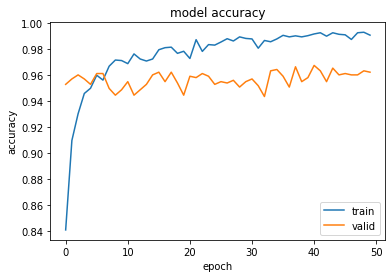

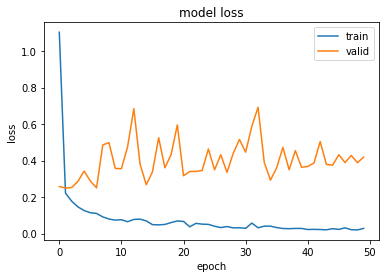

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [0]:
validation_generator_no_shuffle = validation_datagen.flow_from_directory(
        'validation_data',
        target_size=(image_size, image_size),
        batch_size=num_valid_images,
        classes=class_names,
        shuffle=False)


prediction = model_freeze_conv.predict_generator(validation_generator_no_shuffle,1)

Found 985 images belonging to 2 classes.


In [0]:
Y_valid = np.zeros((num_valid_images,1),dtype=int)

step = num_valid_images // num_classes
for ind in range(num_classes):
    Y_valid[ind*step:(ind+1)*step] = ind
    
confmat = confusion_matrix(Y_valid,np.argmax(prediction,axis=1))   

for i0 in range(num_classes):
    sys.stdout.write('[')
    for i1 in range(num_classes):
        sys.stdout.write('{:3d} '.format(confmat[i0,i1]))
    
    sys.stdout.write('], {}\n'.format(class_names[i0]))
    
sys.stdout.flush()

[205 275 ], dog
[163 317 ], cat


### Xception

In [0]:
Xception = applications.Xception(include_top=False, weights='imagenet',
                           input_shape=(image_size,image_size,3))


83689472/83683744 [==============================] - 1s 0us/step


In [0]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import applications

Xception = applications.Xception(include_top=False, weights='imagenet',
                           input_shape=(image_size,image_size,3))

model_freeze_conv = models.Sequential()
model_freeze_conv.add(Xception)
model_freeze_conv.add(layers.Flatten())
model_freeze_conv.add(layers.Dense(256, activation = 'relu'))
model_freeze_conv.add(layers.Dense(2, activation = 'softmax'))

This is what the model looks like now:

In [0]:
model_freeze_conv.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_6 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 514       
Total params: 33,969,450
Trainable params: 33,914,922
Non-trainable params: 54,528
_________________________________________________________________


As you can see, the convolutional base of VGG16 has 14'714'688 parameters, which is very large. The classifier we are adding on top has 
2 million parameters.

Before we compile a layer and train the model, it is very important to __freeze__  the convolutional base. _Freezing_ a layer or a set of layers means preventing their weights from being updated during training. If you don't do this, then the representations that were previously learned by the convolutional base will be modified during training. Because the `Dense` layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, you freeze  a network by setting its `trainable` attribute to `False`: 

In [0]:
print('This is the number of trainable weights'
     'before freezing the conv base:', len(model_freeze_conv.trainable_weights))

vgg16.trainable = False

print('This is the number of trainable weights'
     'after freezing the conv base:', len(model_freeze_conv.trainable_weights))


This is the number of trainable weightsbefore freezing the conv base: 158
This is the number of trainable weightsafter freezing the conv base: 158


With this setup, only the weights from the two `Dense` layers that we added will be trained. That's a total of four weight tensors: two per layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. If we ever modify weight trainability after compilation, we should then recompile the model, or these changes will be ignored.

Now, we can start training our model, with the same data-augmentation configuration that we used in the previous example.

In [0]:
image_size = 150
batch_size = 64
num_train_images = 2880
num_valid_images = 960
num_classes = 2

class_names = ["dog", "cat"]


# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'training_data',
        target_size=(image_size, image_size),
        classes=class_names,
        batch_size=batch_size)

validation_generator = validation_datagen.flow_from_directory(
        'validation_data',
        target_size=(image_size, image_size),
        classes=class_names,
        batch_size=batch_size)

model_freeze_conv.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_freeze_conv.summary()

Found 2907 images belonging to 2 classes.
Found 985 images belonging to 2 classes.
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_6 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 514       
Total params: 33,969,450
Trainable params: 33,914,922
Non-trainable params: 54,528
_________________________________________________________________


In [0]:
name = 'Xception'

tensorboard_2 = TensorBoard(
        log_dir='.\\tensorboard\\' + name + '\\', 
        write_graph=True,
        histogram_freq=0)

In [0]:
epochs = 20

history=model_freeze_conv.fit_generator(
        train_generator,
        steps_per_epoch=num_train_images // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=num_valid_images // batch_size, 
        callbacks=[tensorboard_2])

model_freeze_conv.save_weights('model_transfer_Xception')

Epoch 1/20
45/45 [==============================] - 61s 1s/step - loss: 1.0570 - acc: 0.7362 - val_loss: 12.9059 - val_acc: 0.7937
Epoch 2/20
45/45 [==============================] - 28s 620ms/step - loss: 0.2554 - acc: 0.9019 - val_loss: 0.3090 - val_acc: 0.9469
Epoch 3/20
45/45 [==============================] - 29s 645ms/step - loss: 0.1371 - acc: 0.9476 - val_loss: 0.6330 - val_acc: 0.9375
Epoch 4/20
45/45 [==============================] - 29s 650ms/step - loss: 0.1074 - acc: 0.9648 - val_loss: 0.1611 - val_acc: 0.9521
Epoch 5/20
45/45 [==============================] - 29s 647ms/step - loss: 0.0956 - acc: 0.9592 - val_loss: 0.5057 - val_acc: 0.9167
Epoch 6/20
45/45 [==============================] - 29s 643ms/step - loss: 0.0584 - acc: 0.9803 - val_loss: 0.1727 - val_acc: 0.9469
Epoch 7/20
45/45 [==============================] - 29s 653ms/step - loss: 0.0982 - acc: 0.9638 - val_loss: 0.7717 - val_acc: 0.8281
Epoch 8/20
45/45 [==============================] - 29s 641ms/step - lo

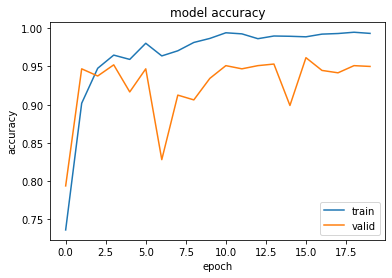

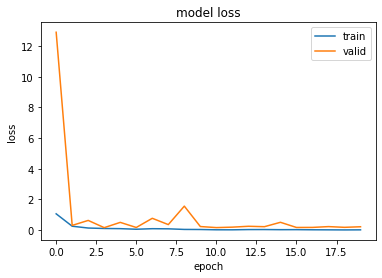

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [0]:
validation_generator_no_shuffle = validation_datagen.flow_from_directory(
        'validation_data',
        target_size=(image_size, image_size),
        batch_size=num_valid_images,
        classes=class_names,
        shuffle=False)


prediction = model_freeze_conv.predict_generator(validation_generator_no_shuffle,1)

Found 985 images belonging to 2 classes.


In [0]:
Y_valid = np.zeros((num_valid_images,1),dtype=int)

step = num_valid_images // num_classes
for ind in range(num_classes):
    Y_valid[ind*step:(ind+1)*step] = ind
    
confmat = confusion_matrix(Y_valid,np.argmax(prediction,axis=1))   

for i0 in range(num_classes):
    sys.stdout.write('[')
    for i1 in range(num_classes):
        sys.stdout.write('{:3d} '.format(confmat[i0,i1]))
    
    sys.stdout.write('], {}\n'.format(class_names[i0]))
    
sys.stdout.flush()

[443  37 ], dog
[ 18 462 ], cat


## Fine Tuning ResNet152 v2

Another widely used technique for model reuse, complementary to feature extraction, is _fine-tuning_. 

Fine-tuning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in this case, the fully connected classifier) and these top layers. This is called _fine-tuning_ because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant at hand.

The steps for fine-tuning are as follows:

1. Add your custom network on top of an already-trained base network
2. Freeze the base network
3. Train the part you added
4. Unfreeze some layers in the base network
5. Jointly train both these layers and the part you added.

We already completed the first three steps in the previous example. As a remainder, this is what our convolutional base looks like:

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_15[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
________________________________________________________________________________________

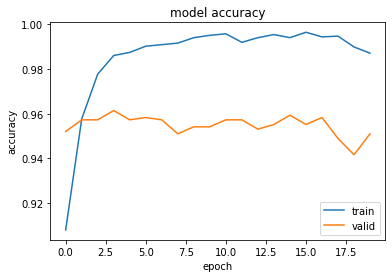

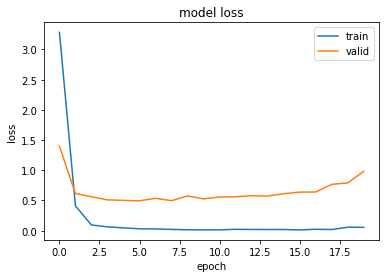

In [0]:
# Part II : Transfer Learning


# General imports
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf

# Shortcuts to keras if (however from tensorflow)
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard 

# Shortcut for displaying images
def plot_img(img):
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.show()
    
# The target image size can be fixed here (quadratic)
# The ImageDataGenerator() automatically scales the images accordingly (aspect ratio is changed)
image_size = 150

ResNet152V2 = applications.ResNet152V2(include_top=False, weights='imagenet',
                           input_shape=(image_size,image_size,3))

# predict_generator requires compilation
ResNet152V2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


ResNet152V2.summary()


## 1. Approach : Extracting Features Using the Pretrained Convolutional Base

### Fast Feature Extraction without Data Augmentation


# These are the class names; this defines the ordering of the classes
class_names = ["dog", "cat"]

# No augmentation only rescaling
datagen = ImageDataGenerator(rescale=1./255)

batch_size = 64
num_train_images = 2880
num_valid_images = 960
num_classes = 2

generator = datagen.flow_from_directory(
        'training_data',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        classes=class_names,
        # this means our generator will only yield batches of 
        # data, no labels
        class_mode=None,  
        # our data will be in order
        shuffle=False)  

# the predict_generator method returns the CNN activation maps 
# of the last layer
bottleneck_features_train = ResNet152V2.predict_generator(generator, 
                                                    num_train_images // batch_size)

print("Shape of last layer feature map of training dataset:", bottleneck_features_train.shape)

# save the output as a Numpy array
np.save('bottleneck_features_train_ResNet152V2.npy', 
        bottleneck_features_train)

generator = datagen.flow_from_directory(
        'validation_data',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        classes=class_names,
        class_mode=None,
        shuffle=False)

bottleneck_features_validation = ResNet152V2.predict_generator(generator, 
                                                         num_valid_images // batch_size)

np.save('bottleneck_features_validation_ResNet152V2.npy', bottleneck_features_validation)

print("Shape of last layer feature map of validation dataset:", bottleneck_features_validation.shape)

##### Load numpy array containing activation maps of training dataset

train_data = np.load('bottleneck_features_train_ResNet152V2.npy')

# the features were saved in order, so recreating the labels is easy
train_labels = np.zeros((num_train_images, num_classes), dtype=int)
for ind in range(num_classes):
    step = num_train_images // num_classes
    train_labels[ind*step:(ind+1)*step,ind]=1

train_labels

##### Load numpy array containing activation maps of validation dataset

validation_data = np.load('bottleneck_features_validation_ResNet152V2.npy')
validation_labels = np.zeros((num_valid_images, num_classes), dtype=int)
for ind in range(num_classes):
    step = num_valid_images // num_classes
    validation_labels[ind*step:(ind+1)*step,ind]=1

validation_labels

#### Defining a Densely Connected Classification Head 

top_model = Sequential()
top_model.add(Flatten(input_shape=train_data.shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(num_classes, activation='softmax'))

top_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

name = 'ResNet152V2_bottleneck_face'

tensorboard_1 = TensorBoard(
        log_dir='.\\tensorboard\\' + name + '\\', 
        write_graph=True,
        histogram_freq=0)

print(train_data.shape)

history = top_model.fit(train_data, train_labels,
          epochs=20,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels),
          callbacks=[tensorboard_1])

top_model.save_weights('model_transfer_learning_without_dataaugmentation')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [0]:
ResNet152V2.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_15[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
________________________________________________________________________________________

We will fine-tune the last three convolutional layers, which means all layers up to `block4_pool` should be frozen, and the layers `block5_conv1`, `block5_conv2`, and `block5_conv3` should be trainable.

In [0]:
ResNet152V2.trainable = True

set_trainable = False

for layer in ResNet152V2.layers:
    if layer.name == 'conv5_block3_preact_bn':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in ResNet152V2.layers[0:]:
    print('layer name = ' + layer.name + ', shape = ' + repr(layer.output_shape)
            + ', trainable = ' + repr(layer.trainable))        
    

layer name = input_15, shape = [(None, 150, 150, 3)], trainable = False
layer name = conv1_pad, shape = (None, 156, 156, 3), trainable = False
layer name = conv1_conv, shape = (None, 75, 75, 64), trainable = False
layer name = pool1_pad, shape = (None, 77, 77, 64), trainable = False
layer name = pool1_pool, shape = (None, 38, 38, 64), trainable = False
layer name = conv2_block1_preact_bn, shape = (None, 38, 38, 64), trainable = False
layer name = conv2_block1_preact_relu, shape = (None, 38, 38, 64), trainable = False
layer name = conv2_block1_1_conv, shape = (None, 38, 38, 64), trainable = False
layer name = conv2_block1_1_bn, shape = (None, 38, 38, 64), trainable = False
layer name = conv2_block1_1_relu, shape = (None, 38, 38, 64), trainable = False
layer name = conv2_block1_2_pad, shape = (None, 40, 40, 64), trainable = False
layer name = conv2_block1_2_conv, shape = (None, 38, 38, 64), trainable = False
layer name = conv2_block1_2_bn, shape = (None, 38, 38, 64), trainable = False
la

Now we can begin fine-tuning the network. First we join the top_model layer on top of the vgg16 model with som top layers unfrozen:

In [0]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import applications


model_fine_tuned = models.Sequential()
model_fine_tuned.add(ResNet152V2)
from tensorflow.keras import optimizers

for layer in top_model.layers[0:]:
    layer.trainable = True
    model_fine_tuned.add(layer)  


model_fine_tuned.compile(optimizer=optimizers.RMSprop(lr=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])  

model_fine_tuned.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Model)          (None, 5, 5, 2048)        58331648  
_________________________________________________________________
flatten_8 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 514       
Total params: 71,439,618
Trainable params: 17,576,706
Non-trainable params: 53,862,912
_________________________________________________________________


In [0]:
# Prepare data augmentation configuration
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'training_data',
        target_size=(image_size, image_size),
        classes=class_names,
        batch_size=batch_size)

validation_generator = validation_datagen.flow_from_directory(
        'validation_data',
        target_size=(image_size, image_size),
        classes=class_names,
        batch_size=batch_size)

Found 2907 images belonging to 2 classes.
Found 985 images belonging to 2 classes.


In [0]:
name = 'ResNet152V2_fine_tuned'

tensorboard_3 = TensorBoard(
        log_dir='.\\tensorboard\\' + name + '\\', 
        write_graph=True,
        histogram_freq=0)

In [0]:
# fine-tune the model
epochs = 50

history=model_fine_tuned.fit_generator(
        train_generator,
        steps_per_epoch=num_train_images // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=num_valid_images // batch_size,
        callbacks=[tensorboard_3])

model_fine_tuned.save_weights('ResNet152V2_fined_tuned.h5')

Epoch 1/50
45/45 [==============================] - 52s 1s/step - loss: 0.4555 - acc: 0.8386 - val_loss: 0.2187 - val_acc: 0.9615
Epoch 2/50
45/45 [==============================] - 25s 560ms/step - loss: 0.3995 - acc: 0.8632 - val_loss: 0.2030 - val_acc: 0.9625
Epoch 3/50
45/45 [==============================] - 25s 553ms/step - loss: 0.3273 - acc: 0.8731 - val_loss: 0.1956 - val_acc: 0.9615
Epoch 4/50
45/45 [==============================] - 25s 551ms/step - loss: 0.3094 - acc: 0.8797 - val_loss: 0.1892 - val_acc: 0.9604
Epoch 5/50
45/45 [==============================] - 25s 550ms/step - loss: 0.2722 - acc: 0.8987 - val_loss: 0.1949 - val_acc: 0.9594
Epoch 6/50
45/45 [==============================] - 24s 544ms/step - loss: 0.2816 - acc: 0.8850 - val_loss: 0.1903 - val_acc: 0.9563
Epoch 7/50
45/45 [==============================] - 24s 540ms/step - loss: 0.2691 - acc: 0.8934 - val_loss: 0.1912 - val_acc: 0.9563
Epoch 8/50
45/45 [==============================] - 24s 537ms/step - los

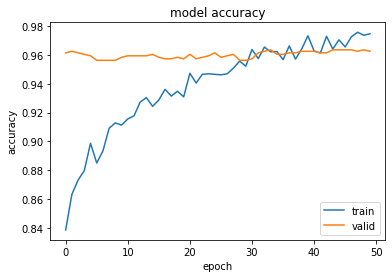

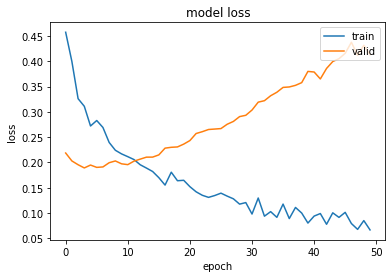

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [0]:
### Fine Tuning unlocking 2 Conv Layer blocks

In [0]:
ResNet152V2.trainable = True

set_trainable = False

for layer in ResNet152V2.layers:
    if layer.name == 'conv5_block2_preact_bn':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in ResNet152V2.layers[0:]:
    print('layer name = ' + layer.name + ', shape = ' + repr(layer.output_shape)
            + ', trainable = ' + repr(layer.trainable))  

layer name = input_15, shape = [(None, 150, 150, 3)], trainable = False
layer name = conv1_pad, shape = (None, 156, 156, 3), trainable = False
layer name = conv1_conv, shape = (None, 75, 75, 64), trainable = False
layer name = pool1_pad, shape = (None, 77, 77, 64), trainable = False
layer name = pool1_pool, shape = (None, 38, 38, 64), trainable = False
layer name = conv2_block1_preact_bn, shape = (None, 38, 38, 64), trainable = False
layer name = conv2_block1_preact_relu, shape = (None, 38, 38, 64), trainable = False
layer name = conv2_block1_1_conv, shape = (None, 38, 38, 64), trainable = False
layer name = conv2_block1_1_bn, shape = (None, 38, 38, 64), trainable = False
layer name = conv2_block1_1_relu, shape = (None, 38, 38, 64), trainable = False
layer name = conv2_block1_2_pad, shape = (None, 40, 40, 64), trainable = False
layer name = conv2_block1_2_conv, shape = (None, 38, 38, 64), trainable = False
layer name = conv2_block1_2_bn, shape = (None, 38, 38, 64), trainable = False
la

In [0]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import applications


model_fine_tuned = models.Sequential()
model_fine_tuned.add(ResNet152V2)
from tensorflow.keras import optimizers

for layer in top_model.layers[0:]:
    layer.trainable = True
    model_fine_tuned.add(layer)  


model_fine_tuned.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])  

model_fine_tuned.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Model)          (None, 5, 5, 2048)        58331648  
_________________________________________________________________
flatten_8 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 514       
Total params: 71,439,618
Trainable params: 22,041,346
Non-trainable params: 49,398,272
_________________________________________________________________


In [0]:
# fine-tune the model
epochs = 50

history=model_fine_tuned.fit_generator(
        train_generator,
        steps_per_epoch=num_train_images // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=num_valid_images // batch_size,
        callbacks=[tensorboard_3])

model_fine_tuned.save_weights('ResNet152V2_fined_tuned_50epochs_batch64.h5')

Epoch 1/50
45/45 [==============================] - 61s 1s/step - loss: 0.1112 - acc: 0.9673 - val_loss: 72503.1258 - val_acc: 0.4958
Epoch 2/50
45/45 [==============================] - 26s 568ms/step - loss: 0.7777 - acc: 0.8540 - val_loss: 128638.6052 - val_acc: 0.4958
Epoch 3/50
45/45 [==============================] - 26s 574ms/step - loss: 0.1681 - acc: 0.9391 - val_loss: 9619.3510 - val_acc: 0.4990
Epoch 4/50
45/45 [==============================] - 25s 560ms/step - loss: 0.1359 - acc: 0.9486 - val_loss: 3233.6239 - val_acc: 0.5906
Epoch 5/50
45/45 [==============================] - 25s 545ms/step - loss: 0.1029 - acc: 0.9669 - val_loss: 102.3766 - val_acc: 0.8729
Epoch 6/50
45/45 [==============================] - 25s 555ms/step - loss: 0.0742 - acc: 0.9768 - val_loss: 9.3374 - val_acc: 0.8656
Epoch 7/50
45/45 [==============================] - 25s 547ms/step - loss: 0.0654 - acc: 0.9782 - val_loss: 0.2574 - val_acc: 0.9583
Epoch 8/50
45/45 [==============================] - 24s

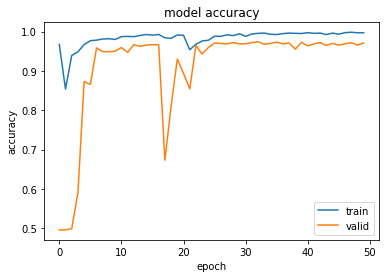

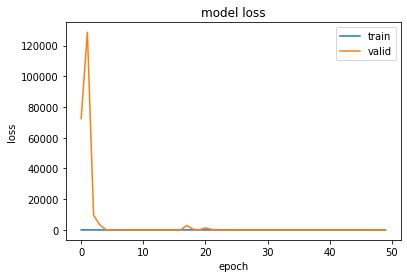

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [0]:
validation_generator_no_shuffle = validation_datagen.flow_from_directory(
        'validation_data',
        target_size=(image_size, image_size),
        batch_size=num_valid_images,
        classes=class_names,
        shuffle=False)


prediction = model_fine_tuned.predict_generator(validation_generator_no_shuffle,1)

Found 985 images belonging to 2 classes.


In [0]:
Y_valid = np.zeros((num_valid_images,1),dtype=int)

step = num_valid_images // num_classes
for ind in range(num_classes):
    Y_valid[ind*step:(ind+1)*step] = ind
    
confmat = confusion_matrix(Y_valid,np.argmax(prediction,axis=1))   

for i0 in range(num_classes):
    sys.stdout.write('[')
    for i1 in range(num_classes):
        sys.stdout.write('{:3d} '.format(confmat[i0,i1]))
    
    sys.stdout.write('], {}\n'.format(class_names[i0]))
    
sys.stdout.flush()

[480   0 ], dog
[268 212 ], cat
